In [1]:
from csv import DictReader

with open('schweidtmann_train.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_train = [r for r in reader]
csv_file.close()

with open('schweidtmann_test.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_test = [r for r in reader]
csv_file.close()

print(len(rows_train), len(rows_test))

430 75


In [2]:
smiles_train, ron_train = [], []
smiles_test, ron_test = [], []

for sample in rows_train:
    if sample['Meas RON'] != 'n.a.':
        smiles_train.append(sample[' SMILES'])
        ron_train.append([float(sample['Meas RON'])])

for sample in rows_test:
    if sample['Meas RON'] != 'n.a.':
        smiles_test.append(sample[' SMILES'])
        ron_test.append([float(sample['Meas RON'])])

print(len(smiles_train), len(smiles_test))
print(len(ron_train), len(ron_test))

284 51
284 51


In [3]:
from graphchem.data import MoleculeGraph, MoleculeDataset
from graphchem.preprocessing import MoleculeEncoder

encoder = MoleculeEncoder(smiles_train)

encoding_train = encoder.encode_many(smiles_train)
encoding_test = encoder.encode_many(smiles_test)

graphs_train = [MoleculeGraph(e[0], e[1], e[2], ron_train[i]) for i, e in enumerate(encoding_train)]
graphs_test = [MoleculeGraph(e[0], e[1], e[2], ron_test[i]) for i, e in enumerate(encoding_test)]

ds_train = MoleculeDataset(graphs_train)
ds_test = MoleculeDataset(graphs_test)

print(len(ds_train), len(ds_test))

284 51


In [4]:
from graphchem.nn import MoleculeGCN
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from copy import deepcopy

train_loader = DataLoader(ds_train, batch_size=16, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=1, shuffle=False)

atom_vocab_size, bond_vocab_size = encoder.vocab_sizes

model = MoleculeGCN(
    atom_vocab_size,
    bond_vocab_size,
    1,
    embedding_dim=64,
    n_messages=3,
    n_readout=3,
    readout_dim=64,
    dropout=0.0
)

init_lr = 0.001
lr_decay = 1e-7
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

train_losses = []
test_losses = []

_lowest_loss = 1e10
_best_weights = None
_best_epoch = 0

model.train()
for epoch in range(500):

    for g in optimizer.param_groups:
        g['lr'] = max(0, init_lr - (epoch * lr_decay))

    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        pred, _, _ = model(batch)
        loss = F.mse_loss(pred, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    test_loss = 0.0
    for batch in test_loader:
        pred, _, _ = model(batch)
        loss = F.mse_loss(pred, batch.y)
        test_loss += loss.detach().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    if test_loss < _lowest_loss:
        _lowest_loss = test_loss
        _best_weights = deepcopy(model.state_dict())
        _best_epoch = epoch

    if epoch % 10 == 0:
        print(f'{epoch}: {train_loss} | {test_loss} | {_lowest_loss}')

model.load_state_dict(_best_weights)

model.eval()


c:\Users\tjkessler\.conda\envs\graphchem\Lib\site-packages\graphchem\data\structs.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(target).type(torch.float).reshape(1, len(target))


0: 270.4911651611328 | 1429.946828272705 | 1429.946828272705
10: 88.07537669866858 | 664.2493297410946 | 450.2728079931409
20: 25.275780959868094 | 726.077336362764 | 322.974974718164
30: 24.39661651933697 | 259.13441748807537 | 258.8361125042041
40: 17.131954354299626 | 246.22596918747706 | 223.07706070779915
50: 13.056305321169571 | 184.9880481321803 | 184.9880481321803
60: 8.89223309637795 | 155.54116689687703 | 155.54116689687703
70: 8.69895271516182 | 148.46103826924866 | 139.69060867652297
80: 8.147858579393844 | 161.76155886390046 | 128.82029606022087
90: 9.038049241186867 | 197.2254438163603 | 121.68539364271176
100: 6.275687352032729 | 128.49902243473952 | 114.52369965021225
110: 6.223301578575457 | 113.97076032836648 | 109.13165741895928
120: 6.954329222020968 | 157.03752182915295 | 109.13165741895928
130: 4.307053752348456 | 118.3777114512335 | 100.35754123176721
140: 4.6849873032368405 | 108.31195327141049 | 100.35754123176721
150: 7.555337905883789 | 157.59299099386908 | 9

MoleculeGCN(
  (emb_atom): Embedding(49, 64)
  (emb_bond): Embedding(34, 64)
  (atom_conv): GeneralConv(64, 64)
  (bond_conv): EdgeConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
  ))
  (readout): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

<Figure size 640x480 with 0 Axes>

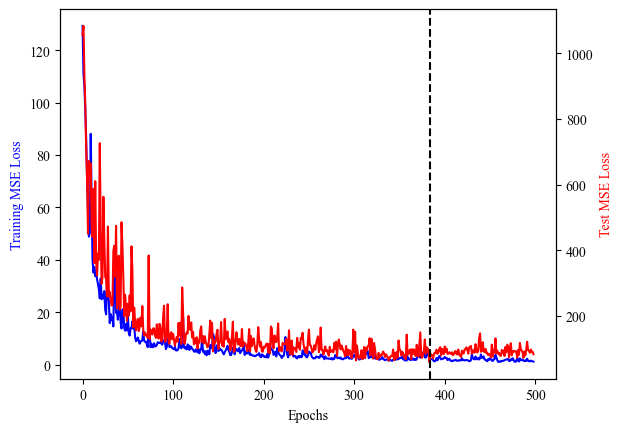

In [5]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots()
ax.plot([i for i in range(len(train_losses[1:]))], train_losses[1:], color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Training MSE Loss', color='blue')
ax2 = ax.twinx()
ax2.plot([i for i in range(len(test_losses[1:]))], test_losses[1:], color='red')
ax2.set_ylabel('Test MSE Loss', color='red')
ax2.axvline(x=_best_epoch, color='black', linestyle='--')
plt.show()

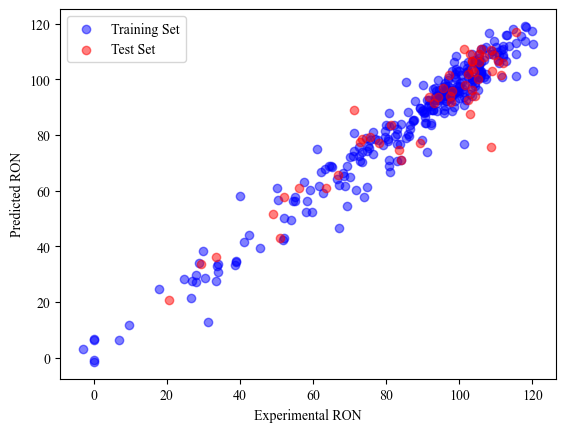

In [6]:
pred_train = [model(mol)[0].detach().numpy() for mol in ds_train]
pred_test = [model(mol)[0].detach().numpy() for mol in ds_test]
exp_train = [mol.y.numpy() for mol in ds_train]
exp_test = [mol.y.numpy() for mol in ds_test]

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(exp_train, pred_train, color='blue', label='Training Set', alpha=0.5)
plt.scatter(exp_test, pred_test, color='red', label='Test Set', alpha=0.5)
plt.xlabel('Experimental RON')
plt.ylabel('Predicted RON')
plt.legend(loc='upper left')
plt.show()

In [7]:
from sklearn.metrics import mean_absolute_error, r2_score

e_test = [e[0] for e in exp_test]
p_test = [p[0] for p in pred_test]

print(f'Test MAE: {mean_absolute_error(e_test, p_test)}')
print(f'Test R2: {r2_score(e_test, p_test)}')

Test MAE: 5.323033809661865
Test R2: 0.8880797305442842
